In [20]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import Sky_area_generator

In [2]:
runName = 'north_stripe_v2.0_10yrs'
opsdb = os.path.join('.', runName + '.db')

In [10]:
filterlist, colors, orders, sqls, info_labels = maf.batches.filterList(all=True)
print(filterlist)

nside = 64
slicer = maf.HealpixSlicer(nside=nside)

bundles = {}
for f in filterlist:
    bundles[f'nvisits {f}'] = maf.MetricBundle(metric=maf.CountMetric(col='observationStartMJD', metricName=f'Nvisits {f}'),
                                 slicer=slicer,
                                 constraint=sqls[f],
                                 info_label=info_labels[f],
                                 runName=runName)
    bundles[f'coadd {f}'] = maf.MetricBundle(metric=maf.Coaddm5Metric(),
                                 slicer=slicer,
                                 constraint=sqls[f],
                                 info_label=info_labels[f],
                                 runName=runName)

('all', 'u', 'g', 'r', 'i', 'z', 'y')
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [11]:
outDir = 'north_stripe_out'
g = maf.MetricBundleGroup(bundles, opsdb, outDir=outDir)
g.runAll()

Querying table None with no constraint for columns ['fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'fieldRA', 'rotSkyPos'].
Found 2089053 visits
Running:  ['nvisits all', 'coadd all']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "u" for columns ['fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'fieldRA', 'rotSkyPos']
Found 141163 visits
Running:  ['nvisits u', 'coadd u']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "r" for columns ['fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'fieldRA', 'rotSkyPos']
Found 461207 visits
Running:  ['nvisits r', 'coadd r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "z" for columns ['fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'fieldRA', 'rotSkyPos']
Found 4

In [14]:
ph = maf.PlotHandler(outDir=outDir, thumbnail=False, figformat='png')

1

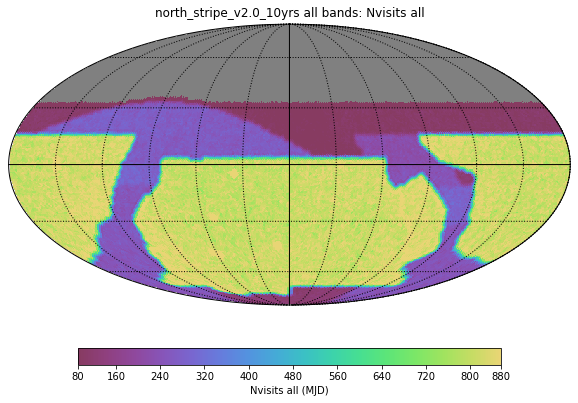

In [16]:
ph.setMetricBundles([bundles['nvisits all']])
ph.plot(maf.HealpixSkyMap(), plotDicts={'percentileClip': 90, 'figsize': (8, 6)})

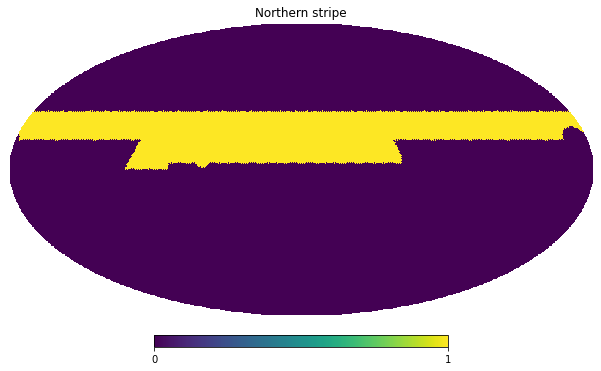

In [19]:
# We could figure out what the pixels are for the northern stripe in a few ways.. but can also use the footprint

sky = Sky_area_generator(nside=nside)
maps, labels = sky.return_maps()

# identify and add northern sky area - include NES
northern_stripe = np.where(sky.dec <= 30, 1, 0)
indx = np.where((northern_stripe > 0) & ((sky.pix_labels == "") | (sky.pix_labels == "nes")), 1, 0)

hp.mollview(np.where(indx, 1, 0), title= "Northern stripe")

In [31]:
north = {}
for b in bundles:
    north[b] = copy.deepcopy(bundles[b])
    north[b].metricValues.mask[np.where(indx==0)] = True

1

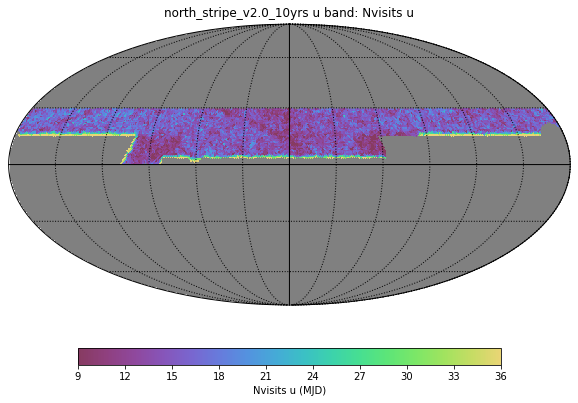

In [36]:
ph.setMetricBundles([north['nvisits u']])
ph.plot(maf.HealpixSkyMap(), plotDicts={'percentileClip': 95, 'figsize': (8, 6)})

In [63]:
summary_stats = [maf.MedianMetric(), maf.MeanMetric(), maf.PercentileMetric(percentile=25)]
for b in north:
    north[b].summaryValues = {}
    north[b].setSummaryMetrics(summary_stats)
    north[b].computeSummaryStats()
for b in bundles:
    bundles[b].summaryValues = {}
    bundles[b].setSummaryMetrics(summary_stats)
    bundles[b].computeSummaryStats()

In [67]:
keys = [f'nvisits {f}' for f in filterlist] + [f'coadd {f}' for f in filterlist]
dn = pd.DataFrame([north[b].summaryValues for b in keys], index=keys)
db = pd.DataFrame([bundles[b].summaryValues for b in keys], index=keys)
db.join(dn, lsuffix=' All sky', rsuffix=' North')

,Median All sky,Mean All sky,25th%ile All sky,Median North,Mean North,25th%ile North
nvisits all,789.000000,597.576016,254.000000,196.000000,201.100727,101.000000
nvisits u,49.000000,40.612261,18.000000,15.000000,15.912080,13.000000
nvisits g,66.000000,62.878639,44.000000,31.000000,31.091491,16.000000
nvisits r,170.000000,132.227479,57.000000,45.000000,45.966753,17.000000
nvisits i,172.000000,134.285005,60.000000,46.000000,46.894594,17.000000
nvisits z,153.000000,115.059825,45.000000,35.000000,34.770718,16.000000
nvisits y,156.000000,114.500949,26.000000,21.000000,26.465091,18.000000
coadd all,27.233540,26.952082,26.707266,26.322454,26.285562,25.903672
coadd u,25.697206,25.444593,25.028949,24.723650,24.740470,24.530101
coadd g,26.683777,26.496228,26.338050,25.937661,25.917204,25.575535
